In [46]:
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import shapely as shp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats

# Central and Mediterranean

In [47]:
mediterrarean_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\Data\EFFIS\mediterranean\EFFIS_BurntAreas_2008-2023_medCountries_greater10ha.shp"
central_europe_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\Data\ML-data-Central-Europe-gridded\historical_ignition\original\EFFIS_Burned_Areas_2008-2023_greater10ha_original.shp"
bosnia_file = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\Data\ML-data-Bosnia-gridded\historical_ignition\original\EFFIS_Burned_Areas_2008-2023_greater10ha_original.shp"

mediterranea_fires = gpd.read_file(mediterrarean_file)
central_europe_fires = gpd.read_file(central_europe_file)
bosnia_fires = gpd.read_file(bosnia_file)

#  Ensure all datasets have the same CRS
common_crs = "EPSG:4326"  # WGS 84

mediterranea_fires = mediterranea_fires.to_crs(common_crs)
central_europe_fires = central_europe_fires.to_crs(common_crs)
bosnia_fires = bosnia_fires.to_crs(common_crs)

# Combine all fires into a single GeoDataFrame
fires = pd.concat([mediterranea_fires, central_europe_fires, bosnia_fires], ignore_index=True)


# Convert columns to datetime
fires['initialdat'] = pd.to_datetime(fires['initialdat'])
fires['finaldate'] = pd.to_datetime(fires['finaldate'])

# Calculate duration in hours
fires['duration'] = fires['finaldate'] - fires['initialdat']
fires['duration_hours'] = fires['duration'].dt.total_seconds() / 3600




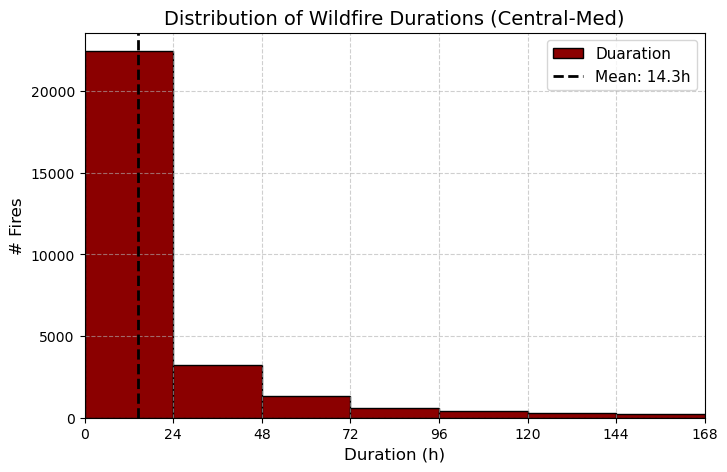

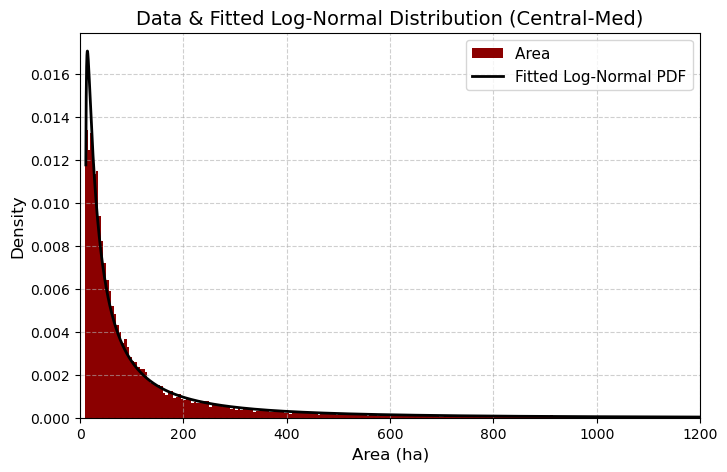

In [48]:

# 🔥 Calculate statistics
q99 = np.percentile(fires['duration_hours'], 99)  # 99th percentile
mean_duration = fires['duration_hours'].mean()  # Mean duration

# 🔥 Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))
fires[fires['duration_hours'] <= q99]['duration_hours'].plot.hist(
    ax=ax, bins=np.arange(0, q99 + 24, 24),  # 24-hour bins
    edgecolor='black', color="darkred", label = 'Duaration'
)

# 📌 Mark mean duration
ax.axvline(mean_duration, color='k', linestyle='dashed', linewidth=2, label=f"Mean: {mean_duration:.1f}h")

# 🏷 Axis Ticks (Every 24 hours + Highlight q99)
ax.set_xlim(0, q99)
tick_positions = np.arange(0, 168 + 24, 24)  # 24h intervals
ax.set_xticks(tick_positions)
ax.set_xticklabels([f"{int(t)}"  for t in tick_positions],  
                    color="black")
ax.tick_params(axis='y', colors="black")

# 🏷 Labels & Grid
ax.set_xlabel("Duration (h)", fontsize=12)
ax.set_ylabel("# Fires", fontsize=12)
ax.set_title("Distribution of Wildfire Durations (Central-Med)", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(fontsize=11)

plt.show()



data = fires['area_ha'].dropna().to_numpy()  # Remove NaNs and convert to NumPy array

# Fit log-normal distribution
shape, loc, scale = stats.lognorm.fit(data, floc=10) 

sigma = shape 
mu = np.log(scale)



# Generate fitted distribution
x = np.linspace(min(data), max(data), 1036764)  # Range of values for PDF
pdf_fitted = stats.lognorm.pdf(x, sigma, loc, scale)  # Compute fitted PDF
bins = np.arange(10, 2001, 5)

# Plot histogram and fitted PDF
plt.figure(figsize=(8, 5))
plt.hist(data, bins=bins, density=True, color="darkred", label="Area ")  # Data histogram
plt.plot(x, pdf_fitted,  'k-', lw=2, label="Fitted Log-Normal PDF")  # Fitted curve
plt.xlim(0, 1200)
plt.xlabel("Area (ha)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=11)
plt.title("Data & Fitted Log-Normal Distribution (Central-Med)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

params_df = pd.DataFrame({"sigma": [shape], "loc": [loc], "scale": [scale]})
params_df.to_csv("lognormal_params_EFFIS_fires_Med_central.csv", index=False)

# North

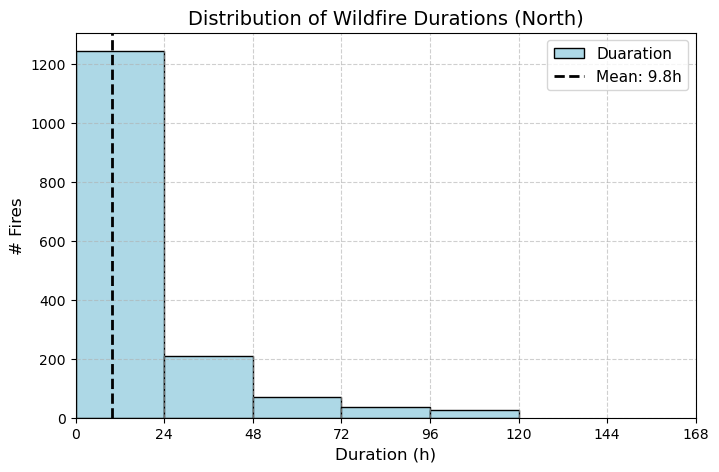

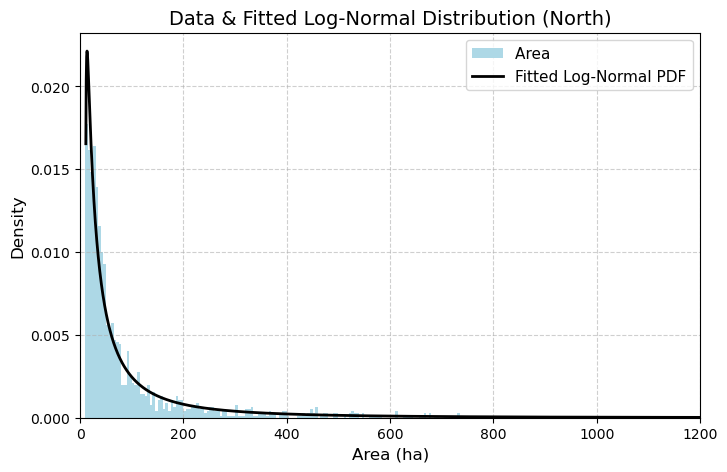

In [49]:
# north 
north = r"O:\Climate-and-Energy-Policy\CERM\Projects\Wildfire\Data\ML-data-Northern-Europe-gridded\historical_ignition\original\EFFIS_Burned_Areas_2008-2023_greater10ha_original.shp"
fires = gpd.read_file(north)

# Convert columns to datetime
fires['initialdat'] = pd.to_datetime(fires['initialdat'])
fires['finaldate'] = pd.to_datetime(fires['finaldate'])

# Calculate duration in hours
fires['duration'] = fires['finaldate'] - fires['initialdat']
fires['duration_hours'] = fires['duration'].dt.total_seconds() / 3600


# 🔥 Calculate statistics
q99 = np.percentile(fires['duration_hours'], 99)  # 99th percentile
mean_duration = fires['duration_hours'].mean()  # Mean duration

# 🔥 Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))
fires[fires['duration_hours'] <= q99]['duration_hours'].plot.hist(
    ax=ax, bins=np.arange(0, q99 + 24, 24),  # 24-hour bins
    edgecolor='black', color="lightblue", label = 'Duaration'
)

# 📌 Mark mean duration
ax.axvline(mean_duration, color='k', linestyle='dashed', linewidth=2, label=f"Mean: {mean_duration:.1f}h")

# 🏷 Axis Ticks (Every 24 hours + Highlight q99)
ax.set_xlim(0, q99)
tick_positions = np.arange(0, 168 + 24, 24)  # 24h intervals
ax.set_xticks(tick_positions)
ax.set_xticklabels([f"{int(t)}"  for t in tick_positions],  
                    color="black")
ax.tick_params(axis='y', colors="black")

# 🏷 Labels & Grid
ax.set_xlabel("Duration (h)", fontsize=12)
ax.set_ylabel("# Fires", fontsize=12)
ax.set_title("Distribution of Wildfire Durations (North)", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(fontsize=11)

plt.show()

data = fires['area_ha'].dropna().to_numpy()  # Remove NaNs and convert to NumPy array

# Fit log-normal distribution
shape, loc, scale = stats.lognorm.fit(data, floc=10) 

sigma = shape 
mu = np.log(scale)

# Generate fitted distribution
x = np.linspace(min(data), max(data), 49445)  # Range of values for PDF
pdf_fitted = stats.lognorm.pdf(x, sigma, loc, scale)  # Compute fitted PDF
bins = np.arange(10, 805, 5)

# Plot histogram and fitted PDF
plt.figure(figsize=(8, 5))
plt.hist(data, bins=bins, density=True, color="lightblue", label="Area ")  # Data histogram
plt.plot(x, pdf_fitted,  'k-', lw=2, label="Fitted Log-Normal PDF")  # Fitted curve
plt.xlim(0, 1200)
plt.xlabel("Area (ha)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=11)
plt.title("Data & Fitted Log-Normal Distribution (North)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

params_df = pd.DataFrame({"sigma": [shape], "loc": [loc], "scale": [scale]})
params_df.to_csv("lognormal_params_EFFIS_fires_North.csv", index=False)